# Spatial-Temporal Experiment

In this notebook, I will be walking through how we can estimate different methods based on the density cubes that we derive.

In [1]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))
# sys.path.insert(0, "/home/emmanuel/code/rbig/")
sys.path.append('/home/emmanuel/code/rbig/')

import pathlib

# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# 
# Experiment Functions
from src.data.esdc import get_dataset
from src.features import Metrics
from sklearn.preprocessing import StandardScaler
# from src.models.density import get_rbig_model
from src.features.temporal import select_period, get_smoke_test_time, TimePeriod
from src.features.spatial import select_region, get_europe, get_spain
from src.experiments.utils import dict_product, run_parallel_step
from src.visualization.spatemp.info_earth.demo_spain import plot_map, plot_monthly_map, plot_ts, plot_ts_error

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.models.utils import subset_indices
# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr

from tqdm import tqdm
import time

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s: %(levelname)s: %(message)s'
)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --ignore-installed "git+https://github.com/dcs4cop/xcube.git#egg=xcube" --pre
# !pip install kdepy

## Experiment Steps

### Global Variables

### Parameters

In [3]:
parameters = {}
parameters['variable'] = [
    'precipitation',
    'gross_primary_productivity',
    'land_surface_temperature',
    'root_moisture',
    'soil_moisture',
    'gross_primary_productivity',
    'precipitation',
]
parameters['region'] = [None]#[get_europe()]
parameters['period'] = [TimePeriod(name="2010", start="Jan-2010", end="Dec-2010")]
parameters['spatial'] = [1]#[1, 7, 3, 1]
parameters['temporal'] = [6]#[1, 1, 6, 46]

# params = list(dict_product(parameters))

params = list(dict_product(parameters))
print(len(params))
smoke_test = True

params = params[0]

7


In [4]:
from rbig.layers.rbig_layer import RBIGLayer
from rbig.stopping import InfoLoss
from rbig.transform.gaussianization import MarginalGaussianization
from rbig.transform.uniformization import KDEUniformization, HistogramUniformization
from rbig.transform.linear import OrthogonalTransform
from rbig.models import GaussianizationModel, RBIG

%autoreload 2

In [5]:
# ======================
# experiment - Data
# ======================
# Get DataCube
logging.info(f"Loading '{params['variable']}' variable")
datacube = get_dataset([params['variable']])
datacube = datacube.resample(time='1MS').mean()

#     t = clip_dataset_by_geometry(datacube, get_spain())

#     datacube = select_region(
#         xr_data=datacube, bbox=get_spain()
#     )[params['variable']]
#     return t

# subset datacube (spatially)
if params['region'] is not None:
    logging.info(f"Selecting region '{params['region'].name}'")
    datacube = select_region(
        xr_data=datacube, bbox=params['region']
    )

# subset datacube (temporally)
logging.info(f"Selecting temporal period: '{params['period'].name}'")
datacube = select_period(xr_data=datacube, period=params['period'])

#     # get datacubes
#     reference_cube_df = get_reference_cube(data=datacube)

# get density cubes
logging.info(f"Getting density cubes: S: {params['spatial']}, T: {params['temporal']}")
density_cube_df = get_density_cubes(
    data=datacube[params['variable']], 
    spatial=params['spatial'], 
    temporal=params['temporal']
)
logging.info(f"Total data: {density_cube_df.shape}")
#     print(density_cube_df.head())

#     # get reference dataframe
#     X, Y = get_common_indices(
#         reference_df=reference_cube_df, 
#         density_df=density_cube_df
#     )
#     print(density_cube_df.values.shape)
#     print(density_cube_df.columns)
# standardize data
logging.info(f"Standardizing data...")
x_transformer = StandardScaler().fit(density_cube_df.values)

density_cube_df_norm = pd.DataFrame(
    data=x_transformer.transform(density_cube_df.values),
    columns=density_cube_df.columns.values,
    index=density_cube_df.index
)


# # get the probability estimates
# logging.info(f"Getting probability estimates...")
# t0 = time.time()
# X_prob = rbig_model.predict_proba(
#     density_cube_df_norm.values, n_trials=20, chunksize=10_000, domain='input'
# )
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")

# X_prob = pd.DataFrame(
#     data=X_prob, 
#     index=density_cube_df_norm.index,
#     columns=['probability']
# )

2020-05-12 23:24:19,438: INFO: Loading 'precipitation' variable
2020-05-12 23:24:22,675: INFO: Selecting temporal period: '2010'
2020-05-12 23:24:22,682: INFO: Getting density cubes: S: 1, T: 6


/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2020-05-12 23:24:23,606: INFO: Total data: (2605212, 6)
2020-05-12 23:24:23,607: INFO: Standardizing data...


In [6]:
def get_rbig_model():
    uniform_clf = HistogramUniformization(bins=50, support_extension=30, alpha=1e-4, n_quantiles=None)
#     uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
    mg_gaussianization = MarginalGaussianization(uniform_clf)
    orth_transform = OrthogonalTransform('random_o')
    rbig_block = RBIGLayer(mg_gaussianization, orth_transform)
    rbig_loss = InfoLoss(tol_layers=20, method='histogram', p_value=0.25)
    rbig_model = GaussianizationModel(rbig_block, rbig_loss, verbose=True)
    return rbig_model


In [7]:
# =========================
# Model - Gaussianization
# =========================
logger.setLevel(logging.INFO)
rbig_model = get_rbig_model()

subsamples = 100_000
subset = subset_indices(density_cube_df_norm.values, subsamples)
logging.info(f"subset: {subset.shape}")
# Gaussianize the data
logging.info(f"Gaussianizing data...")
t0 = time.time()
rbig_model = rbig_model.fit(X=subset)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")


2020-05-12 23:24:26,528: INFO: subset: (100000, 6)
2020-05-12 23:24:26,529: INFO: Gaussianizing data...
Layer: 1, Loss: 3.0748660229269937, NLL: 6.2502
Layer: 2, Loss: 2.227713450305547, NLL: 2.4054
Layer: 3, Loss: 0.34255960649344885, NLL: 2.8408
Layer: 4, Loss: 0.05055666284729021, NLL: 2.6508
Layer: 5, Loss: 0.03001608874221695, NLL: 2.4369
Layer: 6, Loss: 0.06050847226788214, NLL: 2.2907
Layer: 7, Loss: 0, NLL: 2.1711
Layer: 8, Loss: 0, NLL: 2.0606
Layer: 9, Loss: 0.11026026420366541, NLL: 1.8956
Layer: 10, Loss: 0, NLL: 1.8185
Layer: 11, Loss: 0, NLL: 1.7268
Layer: 12, Loss: 0.086410072211903, NLL: 1.5862
Layer: 13, Loss: 0, NLL: 1.5302
Layer: 14, Loss: 0.00036237390461657526, NLL: 1.4756
Layer: 15, Loss: 0.008297986984954875, NLL: 1.4261
Layer: 16, Loss: 0.014594507496342501, NLL: 1.3855
Layer: 17, Loss: 0.009873224221399468, NLL: 1.3512
Layer: 18, Loss: 0, NLL: 1.3251
Layer: 19, Loss: 0.011758969328891311, NLL: 1.3032
Layer: 20, Loss: 0.004931759596233931, NLL: 1.2674
Layer: 21,

In [11]:
from src.experiments.utils import run_parallel_step
from sklearn.utils import gen_batches
from joblib import delayed, Parallel
import joblib

In [12]:
slices = list(gen_batches(density_cube_df_norm.values.shape[0], 1000))

In [13]:
density_cube_df_norm.values[slices[0]].shape, len(slices)

((1000, 6), 2606)

In [14]:
from dask.distributed import Client
client = Client(processes=False)

In [15]:
client

Client Scheduler: inproc://192.168.2.24/15898/1 Dashboard: http://192.168.2.24:8787/status,Cluster Workers: 1 Cores: 28 Memory: 270.18 GB


In [16]:
import dask.dataframe as dd

In [62]:
df_dask = dd.from_pandas(density_cube_df_norm.reset_index(), chunksize=2_000)


In [63]:
df_dask

,time,lat,lon,var_x0,var_x1,var_x2,var_x3,var_x4,var_x5
npartitions=1303,,,,,,,,,
0,datetime64[ns],float64,float64,float32,float32,float32,float32,float32,float32
2000,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
2604000,...,...,...,...,...,...,...,...,...
2605211,...,...,...,...,...,...,...,...,...


In [64]:
df_dask[['var_x0', 'var_x1', 'var_x2', 'var_x3', 'var_x4', 'var_x5']].values

dask.array<values, shape=(nan, 6), dtype=float32, chunksize=(nan, 6), chunktype=numpy.ndarray>

In [14]:
# from dask_ml.wrappers import ParallelPostFit
from sklearn.utils import gen_batches
import joblib
from joblib import Parallel, delayed
slices = list(gen_batches(density_cube_df_norm.values.shape[0], 1000))

In [126]:
clf = ParallelPostFit(rbig_model)
import joblib

In [14]:
with joblib.parallel_backend('dask'):
    jobs = (delayed(rbig_model.score_samples)(
        density_cube_df_norm.values[islice]) for islice in slices
               )

    parallel = Parallel(verbose=1)

    results = parallel(jobs)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 28 concurrent workers.
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by 

2020-05-12 23:23:23,102: ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/_dask.py", line 223, in maybe_to_futures
    f = call_data_futures[arg]
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/_dask.py", line 56, in __getitem__
    ref, val = self._data[id(obj)]
KeyError: 140172999264976

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-df71624544ba>", line 8, in <module>
    results = parallel(jobs)
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/parallel.py", line 1007, in __call__
    

/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


2020-05-12 23:23:24,686: ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/_dask.py", line 223, in maybe_to_futures
    f = call_data_futures[arg]
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/_dask.py", line 56, in __getitem__
    ref, val = self._data[id(obj)]
KeyError: 140172999264976

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-df71624544ba>", line 8, in <module>
    results = parallel(jobs)
  File "/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/joblib/parallel.py", line 1007, in __call__
    

TypeError: can only concatenate str (not "list") to str

In [130]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:58499")
client

/home/emmanuel/.conda/envs/rbig_eo_dev/lib/python3.8/site-packages/distributed/client.py:1115: VersionMismatchWarning: Mismatched versions found

dask
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 2.16.0  |
| scheduler             | 2.15.0  |
| tcp://127.0.0.1:32791 | 2.15.0  |
| tcp://127.0.0.1:36857 | 2.15.0  |
| tcp://127.0.0.1:37394 | 2.15.0  |
| tcp://127.0.0.1:37631 | 2.15.0  |
| tcp://127.0.0.1:55733 | 2.15.0  |
| tcp://127.0.0.1:56943 | 2.15.0  |
| tcp://127.0.0.1:58234 | 2.15.0  |
+-----------------------+---------+

distributed
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 2.16.0  |
| scheduler             | 2.15.1  |
| tcp://127.0.0.1:32791 | 2.15.1  |
| tcp://127.0.0.1:36857 | 2.15.1  |
| tcp://127.0.0.1:37394 | 2.15.1  |
| tcp://127.0.0.1:37631 | 2.15.1  |
| tcp://127.0.0.1:55733 | 2.15.1  |
| tcp://

Client Scheduler: tcp://127.0.0.1:58499 Dashboard: http://127.0.0.1:37977/status,Cluster Workers: 7 Cores: 28 Memory: 270.18 GB


In [119]:
jobs = (delayed(rbig_model.score_samples)(
    density_cube_df_norm.values[islice]) for islice in slices
           )

parallel = Parallel(n_jobs=8,verbose=2)

results = parallel(jobs)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   42.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:  4.4min


KeyboardInterrupt: 

In [86]:
# get the probability estimates
logging.info(f"Getting probability estimates...")
t0 = time.time()
# subsamples = 500_000
# subset = subset_indices(density_cube_df_norm.values, subsamples)

run_parallel_step(rbig_model.score_samples)
X_prob = rbig_model.score_samples(density_cube_df_norm.values)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")
X_prob = pd.DataFrame(
    data=X_prob.squeeze(), 
    index=density_cube_df_norm.index,
    columns=['log_probability']
)
# nll = rbig_model.score(subset.values)
# logging.info(f"Log Likelihood: {nll:.4f}")

2020-05-12 22:39:32,594: INFO: Getting probability estimates...


/home/emmanuel/code/rbig/rbig/density/kde.py:159: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(X))


KeyboardInterrupt: 

In [ ]:
def get_information(df):
    
    df = df.reset_index().set_index(['time', 'lat', 'lon'])
    
#     # convert to datetime
#     df.index['time'] = pd.to_datetime(df.index['time'])


    # remove probabilities greater than 1
#     df['probability'][df['probability'] >= 1.0] = np.nan
    df['probability'] = np.exp(df['log_probability'])

    # create xarray cubes
    probs_cubes = xr.Dataset.from_dataframe(df)

    # resample monthly
    probs_cubes = probs_cubes.resample(time='1MS').mean()

    # shannon info
    probs_cubes['shannon_info'] = -np.log(probs_cubes['probability']) * np.log(2)
    return probs_cubes

In [ ]:
probs_cubes = get_information(X_prob)

In [ ]:
fig, ax = plt.subplots()
probs_cubes.probability.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probability"}
)

fig, ax = plt.subplots()
probs_cubes.log_probability.mean(dim='time').plot(
    ax=ax, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Log Probability"}
)

fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information",}
)

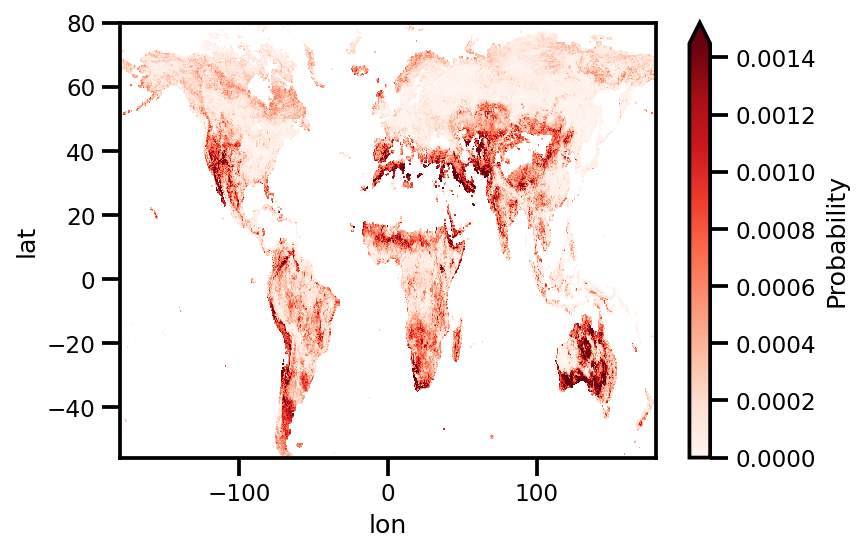

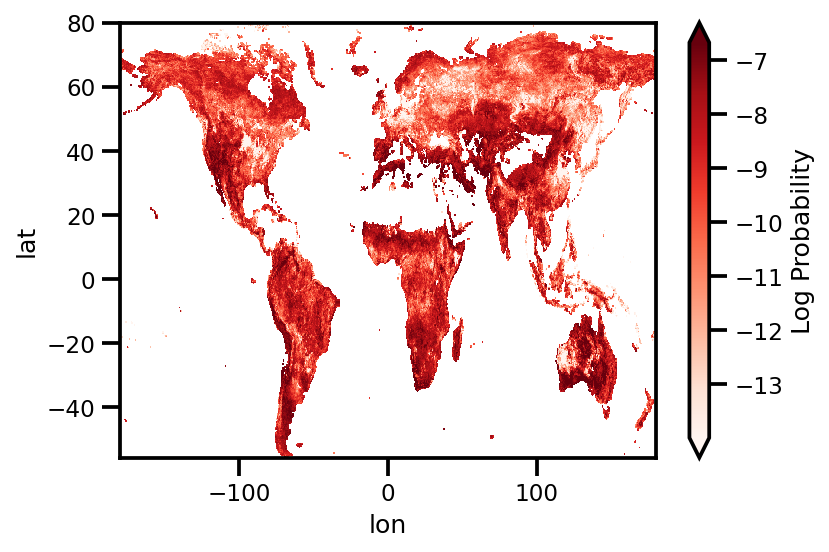

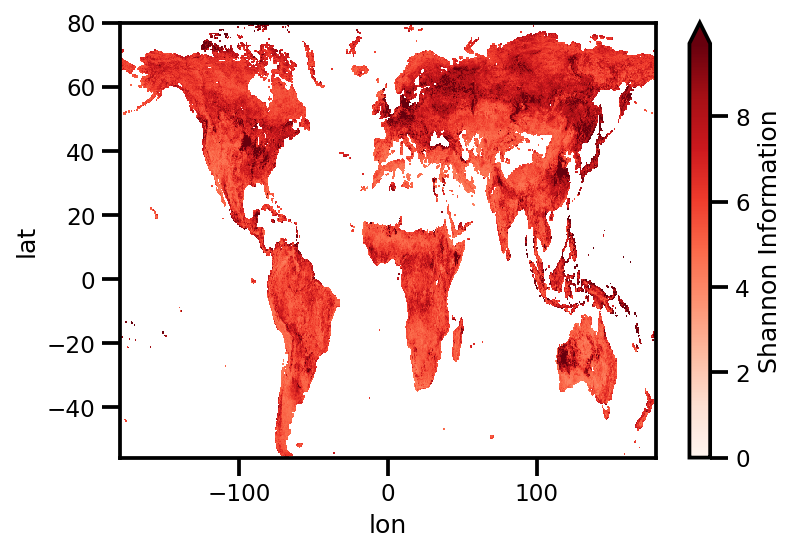

In [77]:
fig, ax = plt.subplots()
probs_cubes.probability.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probability"}
)

fig, ax = plt.subplots()
probs_cubes.log_probability.mean(dim='time').plot(
    ax=ax, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Log Probability"}
)

fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information",}
)

In [37]:
rbig_model.total_correlation()

75.06944987460885

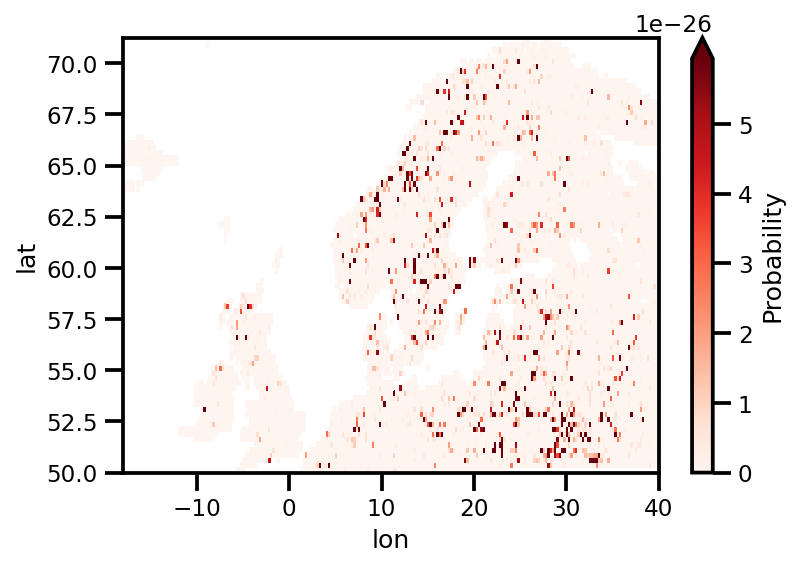

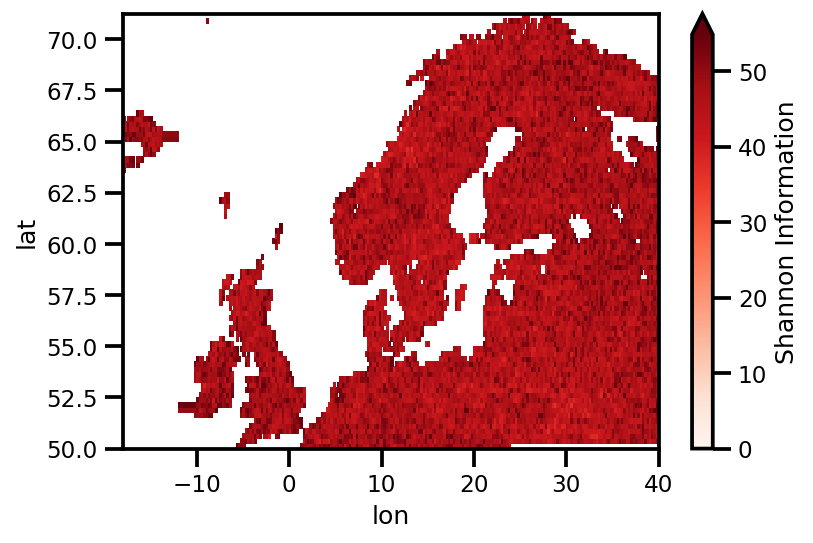

In [38]:
fig, ax = plt.subplots()
probs_cubes.probability.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probability"}
)

fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information"}
)

In [ ]:
!

In [65]:
import rbig

In [ ]:
rbig.

In [ ]:
# =========================
# Model - Gaussianization
# =========================

# Gaussianize the data
logging.info(f"Gaussianizing data...")
t0 = time.time()
rbig_model = get_rbig_model(X=density_cube_df_norm.values)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

# get the probability estimates
logging.info(f"Getting probability estimates...")
t0 = time.time()
X_prob = rbig_model.predict_proba(
    density_cube_df_norm.values, n_trials=20, chunksize=10_000, domain='input'
)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

X_prob = pd.DataFrame(
    data=X_prob, 
    index=density_cube_df_norm.index,
    columns=['probability']
)

In [10]:
variables = [
    'root_moisture',
    'soil_moisture',
    'gross_primary_productivity',
    'land_surface_temperature',
    'precipitation',
]
datacube = get_dataset(variables)
datacube

,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray


In [6]:
mean_cube = datacube.mean(dim=['lat', 'lon']).sel(time=slice('2002', '2010'))
mean_cube = (mean_cube - mean_cube.mean()) / mean_cube.std()

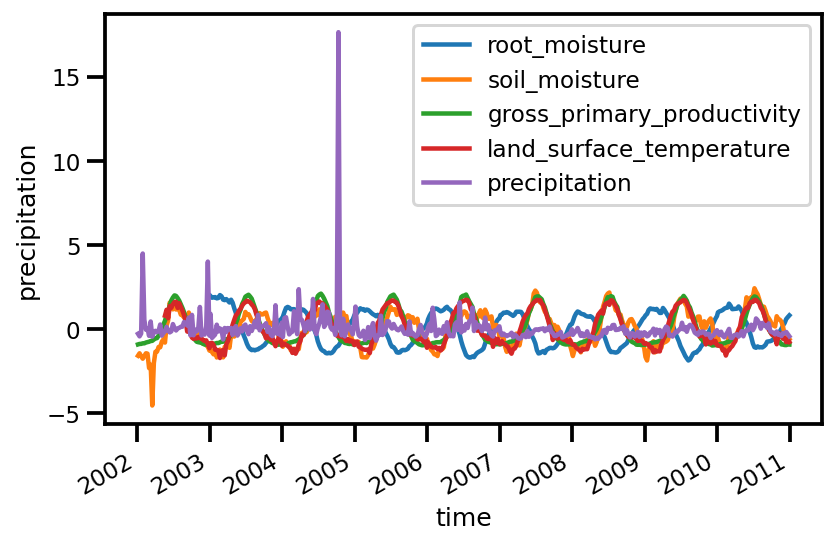

In [26]:
# mean_cube = datacube.mean(dim=['lat', 'lon'])
# mean_cube = (mean_cube - mean_cube.mean) / mean_cube.std()
fig, ax = plt.subplots()
for ivariable in variables:
    mean_cube[ivariable].plot.line(ax=ax, label=ivariable)
    
ax.legend()
plt.tight_layout()
plt.show()

### Experimental Step

In [7]:
datacube = get_dataset([params[0]['variable']])

In [8]:
datacube

,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray


In [64]:
def step(params: Dict, smoke_test: bool=False):
    # ======================
    # experiment - Data
    # ======================
    # Get DataCube
    logging.info(f"Loading '{params['variable']}' variable")
    datacube = get_dataset([params['variable']])
    
#     t = clip_dataset_by_geometry(datacube, get_spain())
    
#     datacube = select_region(
#         xr_data=datacube, bbox=get_spain()
#     )[params['variable']]
#     return t

    # subset datacube (spatially)
    logging.info(f"Selecting region '{params['region'].name}'")
    datacube = select_region(
        xr_data=datacube, bbox=params['region']
    )

    # subset datacube (temporally)
    logging.info(f"Selecting temporal period: '{params['period'].name}'")
    datacube = select_period(xr_data=datacube, period=params['period'])

#     # get datacubes
#     reference_cube_df = get_reference_cube(data=datacube)

    # get density cubes
    logging.info(f"Getting density cubes: S: {params['spatial']}, T: {params['temporal']}")
    density_cube_df = get_density_cubes(
        data=datacube[params['variable']], 
        spatial=params['spatial'], 
        temporal=params['temporal']
    )
    logging.info(f"Total data: {density_cube_df.shape}")
#     print(density_cube_df.head())

#     # get reference dataframe
#     X, Y = get_common_indices(
#         reference_df=reference_cube_df, 
#         density_df=density_cube_df
#     )
#     print(density_cube_df.values.shape)
#     print(density_cube_df.columns)
    # standardize data
    logging.info(f"Standardizing data...")
    x_transformer = StandardScaler().fit(density_cube_df.values)
    
    density_cube_df_norm = pd.DataFrame(
        data=x_transformer.transform(density_cube_df.values),
        columns=density_cube_df.columns.values,
        index=density_cube_df.index
    )

    # =========================
    # Model - Gaussianization
    # =========================
    
    # Gaussianize the data
    logging.info(f"Gaussianizing data...")
    t0 = time.time()
    rbig_model = get_rbig_model(X=density_cube_df_norm.values)
    t1 = time.time() - t0
    logging.info(f"Time Taken: {t1:.2f} secs")
    
    # get the probability estimates
    logging.info(f"Getting probability estimates...")
    t0 = time.time()
    X_prob = rbig_model.predict_proba(
        density_cube_df_norm.values, n_trials=20, chunksize=10_000, domain='input'
    )
    t1 = time.time() - t0
    logging.info(f"Time Taken: {t1:.2f} secs")
    
    X_prob = pd.DataFrame(
        data=X_prob, 
        index=density_cube_df_norm.index,
    )
    
    return density_cube_df, rbig_model, x_transformer, X_prob


In [ ]:
density_cube_df, rbig_model, X_transformer, X_prob = step(params[0], smoke_test=True)

2020-05-10 12:25:34,967:INFO:Loading 'root_moisture' variable
2020-05-10 12:25:35,665:INFO:Selecting region 'spain'
2020-05-10 12:25:35,684:INFO:Selecting temporal period: 'TimePeriod(name='201001_201012', start='Jan-2002', end='Dec-2010')'
2020-05-10 12:25:35,689:INFO:Getting density cubes: S: 7, T: 1
2020-05-10 12:25:36,684:INFO:Total data: (165232, 49)
2020-05-10 12:25:36,685:INFO:Standardizing data...
2020-05-10 12:25:36,845:INFO:Gaussianizing data...
2020-05-10 12:42:13,761:INFO:Time Taken: 996.91 secs
2020-05-10 12:42:13,762:INFO:Getting probability estimates...


In [91]:
density_cube_df.head()

var_x0      prob
time       lat    lon                       
2010-01-05 43.625 -8.375  0.159887  0.263087
                  -8.125  0.159701  0.260425
                  -7.875  0.446944  0.147057
                  -7.625  0.486189  0.095024
                  -7.375  0.158740  0.245753

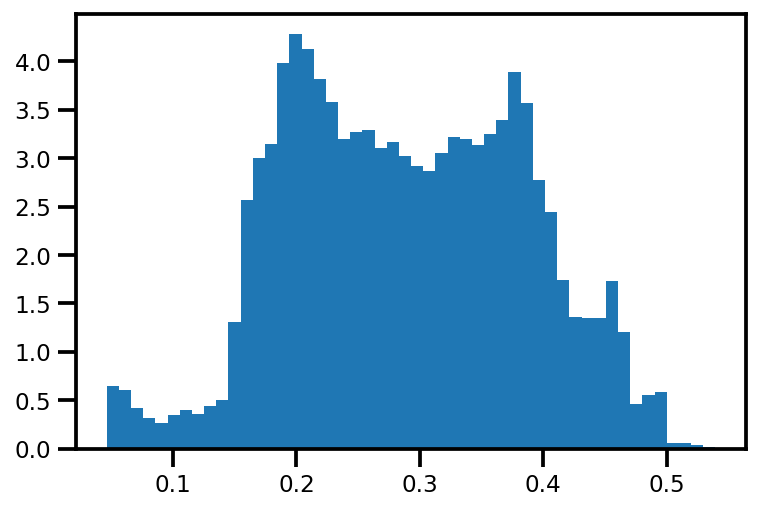

In [92]:
plt.hist(density_cube_df['var_x0'].squeeze(), bins=50, density=True);

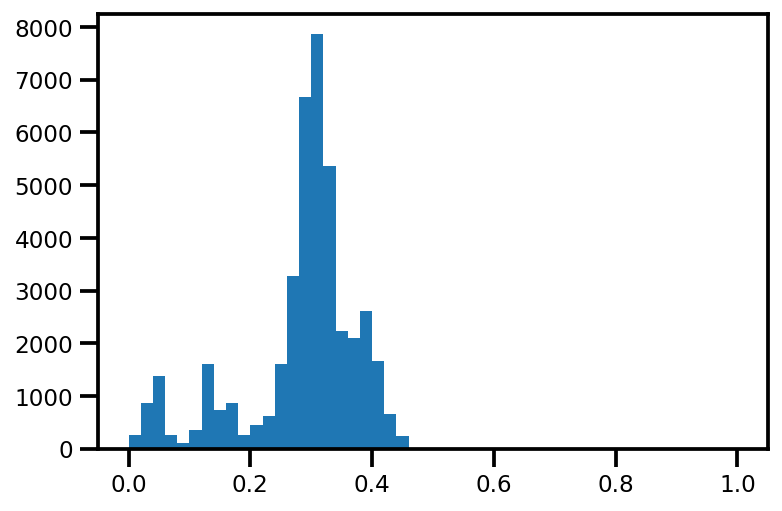

In [93]:
plt.hist(density_cube_df['prob'].squeeze(), bins=50, range=(0, 1.0));

In [85]:
X.head()

var_x0
time       lat    lon             
2010-01-05 43.625 -8.375 -1.336740
                  -8.125 -1.338682
                  -7.875  1.657619
                  -7.625  2.066988
                  -7.375 -1.348702

### Visualization

In [ ]:
prob_cube = xr.from_dataframe(X_prob)

In [ ]:
datacube.mean(dim='time').plot(vmin=0)
plt.tight_layout()

## Extra Features

So in the previous example, I took data as is. Meaning they were just samples and I used a density estimator. For this example, I will add some extra features and then we can compare how the probability estimates change.

In [ ]:
parameters = {}
parameters['variable'] = 'root_moisture'
#     'root_moisture',
#     'soil_moisture',
#     'gross_primary_productivity',
#     'land_surface_temperature',
#     'precipitation',
# ]
parameters['region'] = get_spain()
parameters['period'] = TimePeriod(name="200201_201012", start="Jan-2002", end="Dec-2010")
parameters['spatial'] = 3
parameters['temporal'] = 2

In [ ]:
density_cube_df, rbig_model, X_transformer, X_prob = step(parameters, smoke_test=True)

In [87]:
X.head()

var_x0      prob
time       lat    lon                       
2010-01-05 43.625 -8.375 -1.336740  0.263087
                  -8.125 -1.338682  0.260425
                  -7.875  1.657619  0.147057
                  -7.625  2.066988  0.095024
                  -7.375 -1.348702  0.245753

In [75]:
X_prob.shape, X_prob.max(), X_prob.min()

((42044,), 14.59578649691485, 0.0)

(array([  36.,  170.,   11.,   27.,   30.,   81.,  169.,  283.,  312.,
         256.,  284.,  465.,  283.,  164.,   63.,   43.,   40.,   43.,
          43.,   25.,   11.,   19.,   19.,   55.,   26.,   25.,  213.,
         142.,  387.,  306.,  607.,  278.,  214.,  117.,  106.,  131.,
         357.,  379.,  102.,   75.,   42.,  100.,   41.,   44.,   49.,
          36.,   59.,   32.,   44.,  366.,  137.,   71.,  126.,  163.,
         158.,  208.,  281.,  671.,  441.,  874.,  821.,  457.,  468.,
        1263., 1046., 1161., 1676., 2260., 2338., 1609., 1064., 1477.,
        2137., 1832., 1471.,  514.,  627.,  747.,  321.,  541.,  431.,
         323.,  445.,  439.,  471.,  589.,  740.,  532.,  603.,  466.,
         639.,  398.,  319.,  244.,  301.,  270.,  146.,   73.,   96.,
         347.]),
 array([0.   , 0.004, 0.009, 0.013, 0.018, 0.022, 0.027, 0.031, 0.035,
        0.04 , 0.044, 0.049, 0.053, 0.057, 0.062, 0.066, 0.071, 0.075,
        0.08 , 0.084, 0.088, 0.093, 0.097, 0.102, 0.106, 0.1

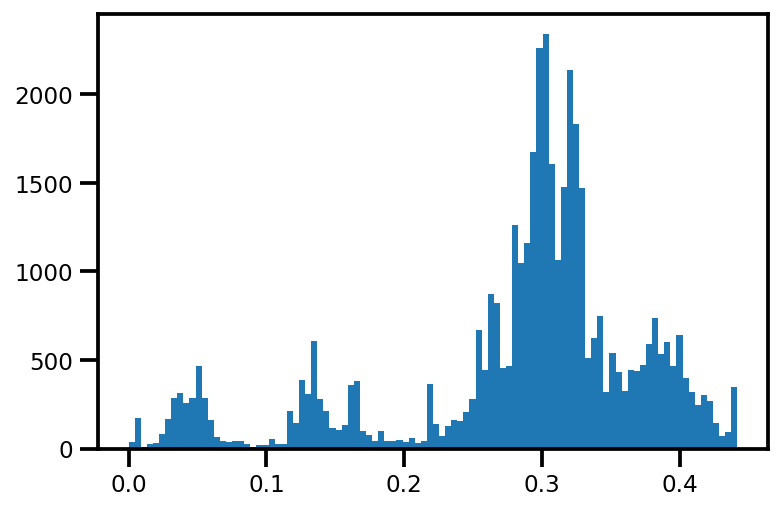

In [73]:
plt.hist(X_prob[X_prob < 1.], bins=100)

In [7]:
res

{'rv_coeff': 0.9697245,
 'rv_x_norm': 26692.102,
 'rv_y_norm': 77907.13,
 'rv_xy_norm': 2016547100.0,
 'rbig_H_x': 1.855240533094599,
 'rbig_H_y': 1.0902273375895914,
 'rbig_I_xy': 5.405821100129361,
 'rbig_vi_coeff': 3.801045104354525}

In [69]:
from prefect import task, Flow, Parameter

@task # get Dataset
def get_dataset(variable: str)-> xr.Dataset:
    return xr.open_zarr(str(filename))[[variable]]

@task # subset datacube
def cube_spatial_subset(xr_data: xr.Dataset, bbox: Region) -> xr.Dataset:
    """Function to spatially subset an xarray dataset from a bounding box."""
    # get bounding box
    bbox = shapely.geometry.box(
        bbox.lonmin,
        bbox.latmin,
        bbox.lonmax,
        bbox.latmax
    )
    # subset datacube
    return clip_dataset_by_geometry(xr_data, bbox)

@task 
def cube_temporal_subset(xr_data: xr.DataArray, period: Tuple[str, str]) -> xr.DataArray:
    """Function to temporally subset an xarray dataset from a tuple of
    start date and end date
    """
    return xr_data.sel(time=slice(period.start, period.end))

@task # get reference cube
def get_reference_cube(data: xr.DataArray) -> pd.DataFrame:
    """Wrapper Function to get reference cube"""
    return data.to_dataframe().dropna().reorder_levels(levels)

@task # get density cubes
def get_density_cubes(data: xr.DataArray, spatial: int, temporal: int) -> pd.DataFrame:
    """Wrapper Function to get density cubes from a dataarray"""
    return DensityCubes(
        spatial_window=spatial,
        time_window=temporal
    ).get_minicubes(data).reorder_levels(levels)
    
@task # get common indices
def get_common_indices(
    reference_df: pd.DataFrame, density_df: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    idx = density_df.index.intersection(reference_df.index)
    return reference_df.loc[idx,:], density_df.loc[idx, :]

@task # standardize the data before
def standardizer_data(X: pd.DataFrame, Y: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    # standardizer
    normalizer = StandardScaler(with_mean=True, with_std=True)
    
    # standardize X values
    X_values = normalizer.fit_transform(X.values)
    X = pd.DataFrame(data=X_values, index=X.index, columns=X.columns)
    
    # standardize Y Values
    Y_values = normalizer.fit_transform(Y.values)
    Y = pd.DataFrame(data=Y_values, index=Y.index, columns=Y.columns)
    
    return X, Y

@task
def get_similarity_scores(X_ref: pd.DataFrame, Y_compare: pd.DataFrame) -> Dict:
    
    # RV Coefficient
    rv_results = rv_coefficient(X_ref, Y_compare)
    
#     # CKA Coefficient
#     cka_results = cka_coefficient(X_ref, Y_compare)
    
    # RBIG Coefficient
    rbig_results = rbig_it_measures(X_ref, Y_compare)
    
    results = {
        **rv_results,
#         **cka_results,
        **rbig_results
    }
    
    return results

### Experiment Run

In [71]:
# variable = 'gross_primary_productivity'
# region = get_europe()

# datacube = get_dataset(variable)

# datacube = subset_cube(xr_data=datacube, bbox=region)


In [72]:
logger.setLevel(logging.INFO)

with Flow("Experiment-Step") as flow:
    
    # ======================
    # experiment parameters
    # ======================
    variable = Parameter("variable", default='gross_primary_productivity')
    region = Parameter("region", default=get_europe())
    period = Parameter("period", default=get_test_time())
    spatial = Parameter("spatial", default=1)
    temporal = Parameter("temporal", default=3)
    
    # ======================
    # experiment - Data
    # ======================
    # Get DataCube
    datacube = get_dataset(variable)
    
    # subset datacube (spatially)
    datacube = cube_spatial_subset(xr_data=datacube, bbox=region)[variable]

    # subset datacube (temporally)
    datacube = cube_temporal_subset(xr_data=datacube, period=period)
    
    # get datacubes
    reference_cube_df = get_reference_cube(data=datacube)
    
    # get density cubes
    density_cube_df = get_density_cubes(
        data=datacube, 
        spatial=spatial, 
        temporal=temporal
    )
    
    # get reference dataframe
    dfs = get_common_indices(
        reference_df=reference_cube_df, 
        density_df=density_cube_df
    )
    
    # standardize data
    dfs = standardizer_data(X=dfs[0], Y=dfs[1])
    
    # ======================
    # experiment - Methods
    # ======================
    res = get_similarity_scores(X_ref=dfs[0], Y_compare=dfs[1])

In [73]:
    
state = flow.run()

[2020-05-01 10:16:21] INFO - prefect.FlowRunner | Beginning Flow run for 'Experiment-Step'
2020-05-01 12:16:21,361:INFO:Beginning Flow run for 'Experiment-Step'
[2020-05-01 10:16:21] INFO - prefect.FlowRunner | Starting flow run.
2020-05-01 12:16:21,372:INFO:Starting flow run.
[2020-05-01 10:16:21] INFO - prefect.TaskRunner | Task 'variable': Starting task run...
2020-05-01 12:16:21,411:INFO:Task 'variable': Starting task run...
[2020-05-01 10:16:21] INFO - prefect.TaskRunner | Task 'variable': finished task run for task with final state: 'Success'
2020-05-01 12:16:21,424:INFO:Task 'variable': finished task run for task with final state: 'Success'
[2020-05-01 10:16:21] INFO - prefect.TaskRunner | Task 'region': Starting task run...
2020-05-01 12:16:21,454:INFO:Task 'region': Starting task run...
[2020-05-01 10:16:21] INFO - prefect.TaskRunner | Task 'region': finished task run for task with final state: 'Success'
2020-05-01 12:16:21,467:INFO:Task 'region': finished task run for task wi

In [74]:
state.result[res].result

{'rv_coeff': 0.9697258,
 'rv_x_norm': 26692.072,
 'rv_y_norm': 77907.49,
 'rv_xy_norm': 2016556900.0,
 'rbig_H_x': 1.855240533094599,
 'rbig_H_y': 1.1286197933913034,
 'rbig_I_xy': 5.499353957238775,
 'rbig_vi_coeff': 3.8004736863738287}